In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense
from datetime import datetime

# Read your CSV file
df = pd.read_csv('./data1.csv')

# Drop rows with missing values
df.dropna(inplace=True)

# Filter out infinity values only from numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
for column in numeric_columns:
    is_infinite = np.isinf(df[column])
    df = df[~is_infinite]

# Remove columns with all 0 values
zero_columns = df.columns[(df == 0).all()]
df = df.drop(columns=zero_columns)

print('The dataset contains', df.shape[0], 'rows and', df.shape[1], 'columns')
df.head()


The dataset contains 4618 rows and 118 columns


,R1-PA1:VH,R1-PM1:V,R1-PA2:VH,R1-PM2:V,R1-PA3:VH,R1-PM3:V,R1-PA4:IH,R1-PM4:I,R1-PA5:IH,R1-PM5:I,...,R4-PM12:I,R4:F,R4:DF,R4-PA:Z,R4-PA:ZH,R4:S,relay1_log,relay2_log,relay4_log,marker
0,70.399324,127673.0908,-49.572308,127648.0176,-169.578319,127723.2374,65.689611,605.91099,-57.003571,626.78553,...,11.71904,59.999,0.01,6.341832,0.077897,0,0,0,0,Natural
1,73.688102,130280.7109,-46.300719,130255.6377,-166.278082,130355.9307,71.831719,483.59351,-50.947407,500.98896,...,9.70483,60.005,0.00,8.141328,0.027210,0,0,0,0,Natural
2,73.733939,130305.7842,-46.254883,130280.7109,-166.232245,130381.0040,71.808800,483.59351,-50.913030,500.98896,...,10.07105,60.005,0.00,8.162755,0.026663,0,0,0,0,Natural
3,74.083443,130581.5902,-45.899649,130556.5169,-165.882741,130656.8100,72.152575,482.86107,-50.437475,499.15786,...,9.15550,60.003,0.00,8.135292,0.026595,0,0,0,0,Natural
4,74.553268,131083.0556,-45.424094,131057.9823,-165.424375,131158.2754,72.118198,484.50906,-50.013486,497.69298,...,7.14129,60.001,0.00,8.036023,0.033641,0,0,0,0,Natural


In [2]:
print(df.columns)

Index(['R1-PA1:VH', 'R1-PM1:V', 'R1-PA2:VH', 'R1-PM2:V', 'R1-PA3:VH',
       'R1-PM3:V', 'R1-PA4:IH', 'R1-PM4:I', 'R1-PA5:IH', 'R1-PM5:I',
       ...
       'R4-PM12:I', 'R4:F', 'R4:DF', 'R4-PA:Z', 'R4-PA:ZH', 'R4:S',
       'relay1_log', 'relay2_log', 'relay4_log', 'marker'],
      dtype='object', length=118)


In [3]:
df.marker.unique()

array(['Natural', 'Attack'], dtype=object)

In [4]:
# Use one-hot encoding to convert the 'marker' column
df_encoded = pd.get_dummies(df, columns=['marker'], drop_first=True)

# Check the column names after encoding
print(df_encoded.columns)

# Calculate the correlation matrix
corr_matrix = df_encoded.corr()
corr_matrix

Index(['R1-PA1:VH', 'R1-PM1:V', 'R1-PA2:VH', 'R1-PM2:V', 'R1-PA3:VH',
       'R1-PM3:V', 'R1-PA4:IH', 'R1-PM4:I', 'R1-PA5:IH', 'R1-PM5:I',
       ...
       'R4-PM12:I', 'R4:F', 'R4:DF', 'R4-PA:Z', 'R4-PA:ZH', 'R4:S',
       'relay1_log', 'relay2_log', 'relay4_log', 'marker_Natural'],
      dtype='object', length=118)


,R1-PA1:VH,R1-PM1:V,R1-PA2:VH,R1-PM2:V,R1-PA3:VH,R1-PM3:V,R1-PA4:IH,R1-PM4:I,R1-PA5:IH,R1-PM5:I,...,R4-PM12:I,R4:F,R4:DF,R4-PA:Z,R4-PA:ZH,R4:S,relay1_log,relay2_log,relay4_log,marker_Natural
R1-PA1:VH,1.000000,0.039062,-0.374523,0.059223,-0.381363,0.061578,0.969965,-0.066157,-0.385331,-0.073567,...,-0.032880,-0.018469,-0.008323,0.004712,-0.029864,-0.003431,-0.000949,-0.022765,-0.024315,0.018166
R1-PM1:V,0.039062,1.000000,-0.002344,0.797069,-0.042450,0.816492,0.011313,-0.793783,-0.024257,-0.235912,...,-0.710155,-0.067965,-0.063321,0.027068,-0.559978,-0.260078,-0.145835,-0.144658,-0.202114,0.028444
R1-PA2:VH,-0.374523,-0.002344,1.000000,-0.013156,-0.235450,0.003904,-0.371462,0.023665,0.936113,0.033282,...,0.004914,-0.011679,0.000560,-0.062977,0.010036,-0.044253,0.005964,0.002047,0.000664,-0.051747
R1-PM2:V,0.059223,0.797069,-0.013156,1.000000,-0.038822,0.981457,0.038378,-0.676050,-0.037168,-0.373988,...,-0.501337,-0.079078,-0.138735,0.030143,-0.422239,-0.223942,-0.081629,-0.090482,-0.136562,-0.008285
R1-PA3:VH,-0.381363,-0.042450,-0.235450,-0.038822,1.000000,-0.057240,-0.379155,0.040091,-0.219582,0.037600,...,0.023338,0.021760,0.009870,0.039125,-0.005393,0.028572,0.020326,0.002843,-0.000060,-0.080574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R4:S,-0.003431,-0.260078,-0.044253,-0.223942,0.028572,-0.227450,-0.025899,0.234044,-0.031839,0.058035,...,0.284767,0.034587,0.051837,-0.007225,0.192321,1.000000,-0.000685,-0.000839,-0.000839,-0.017397
relay1_log,-0.000949,-0.145835,0.005964,-0.081629,0.020326,-0.085845,-0.006383,0.110534,0.005307,0.040767,...,0.036502,0.008443,0.018230,-0.003074,0.067925,-0.000685,1.000000,-0.000531,-0.000531,-0.010999
relay2_log,-0.022765,-0.144658,0.002047,-0.090482,0.002843,-0.066766,-0.003280,0.140584,-0.001540,-0.009200,...,0.069059,-0.171301,-0.023661,-0.003751,0.083467,-0.000839,-0.000531,1.000000,-0.000650,0.027676
relay4_log,-0.024315,-0.202114,0.000664,-0.136562,-0.000060,-0.155563,0.020689,0.166586,0.020392,0.002304,...,0.288073,0.012554,-0.008525,-0.005673,0.135080,-0.000839,-0.000531,-0.000650,1.000000,0.007102


In [5]:
corr_matrix = df_encoded.corr()

# Create a set to store the columns to remove
columns_to_remove = set()

# Define the correlation threshold
correlation_threshold = 0.7  # Adjust this threshold as needed

# Iterate through the columns and find pairs with correlations above or below the threshold
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        correlation_value = corr_matrix.iloc[i, j]
        if abs(correlation_value) >= correlation_threshold:
            col_i = corr_matrix.columns[i]
            col_j = corr_matrix.columns[j]

            # Choose one column to remove (you can customize this logic)
            # For example, you can choose the column with the shorter name
            if len(col_i) <= len(col_j):
                columns_to_remove.add(col_j)
            else:
                columns_to_remove.add(col_i)

# Remove the identified columns
df_encoded_filtered = df_encoded.drop(columns=columns_to_remove)

In [6]:
def correlation_map(f_data, f_feature, f_number):
    """
    Develops and displays a heatmap plot referenced to a primary feature of a dataframe, highlighting
    the correlation among the 'n' mostly correlated features of the dataframe.
    
    Keyword arguments:
    
    f_data      Tensor containing all relevant features, including the primary.
                Pandas dataframe
    f_feature   The primary feature.
                String
    f_number    The number of features most correlated to the primary feature.
                Integer
    """
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    with sns.axes_style("white"):
        f_fig, f_ax = plt.subplots(figsize=(12, 12))
        sns.heatmap(f_correlation, mask=f_mask, vmin=-1, vmax=1, square=True,
                    center=0, annot=False, annot_kws={"size": 8}, cmap="PRGn")
    plt.show()

In [7]:
print(df_encoded_filtered.columns)

Index(['R1:DF', 'R1:S', 'R2-PA:Z', 'R3-PM3:V', 'R3-PA4:IH', 'R3-PA5:IH',
       'R3-PA6:IH', 'R3-PA11:IH', 'R3-PA12:IH', 'R3:F', 'R3:DF', 'R3-PA:Z',
       'R3-PA:ZH', 'R4-PA5:IH', 'R4-PA6:IH', 'R4-PM6:I', 'R4-PA7:VH',
       'R4-PA9:VH', 'R4-PM9:V', 'R4-PA11:IH', 'R4-PA12:IH', 'R4:F', 'R4:DF',
       'R4-PA:Z', 'R4-PA:ZH', 'R4:S', 'relay1_log', 'relay2_log', 'relay4_log',
       'marker_Natural'],
      dtype='object')


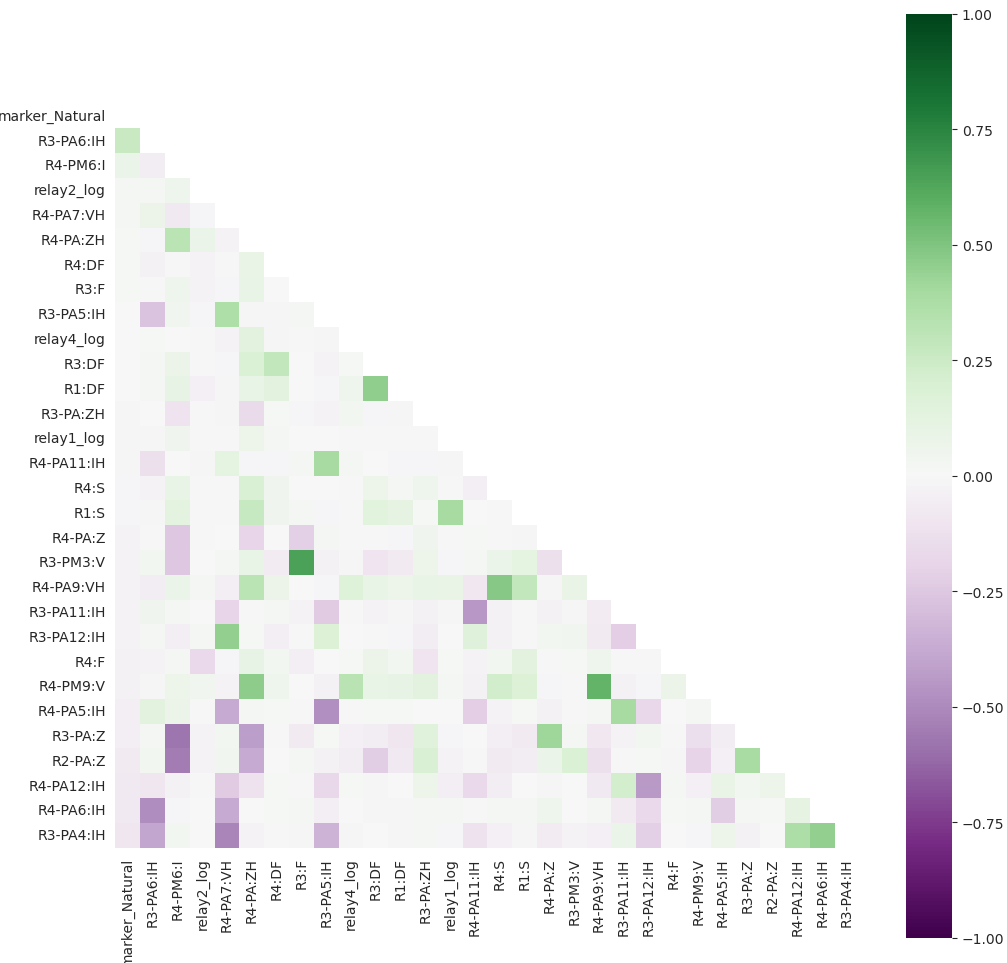

In [8]:
# Select 'marker_Natural' as the primary feature
correlation_map(df_encoded_filtered, 'marker_Natural', 37)

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


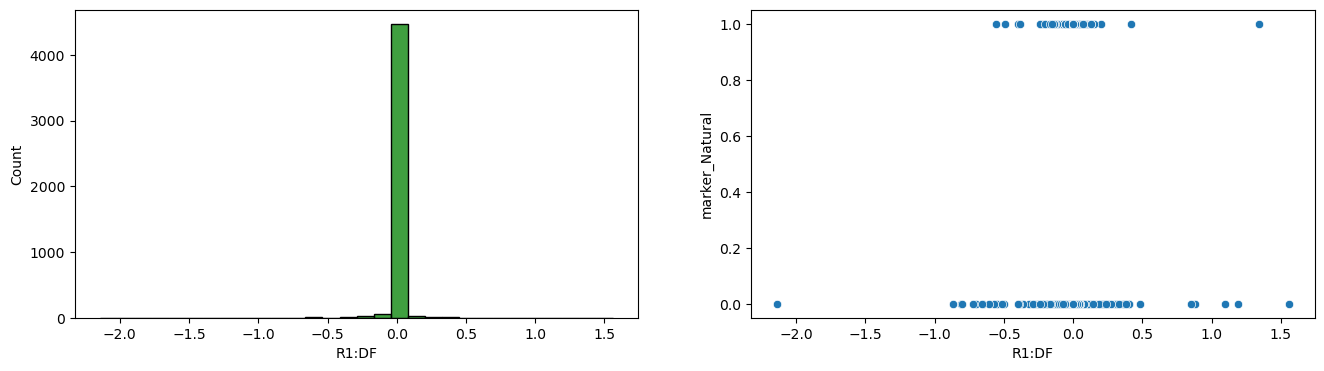

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


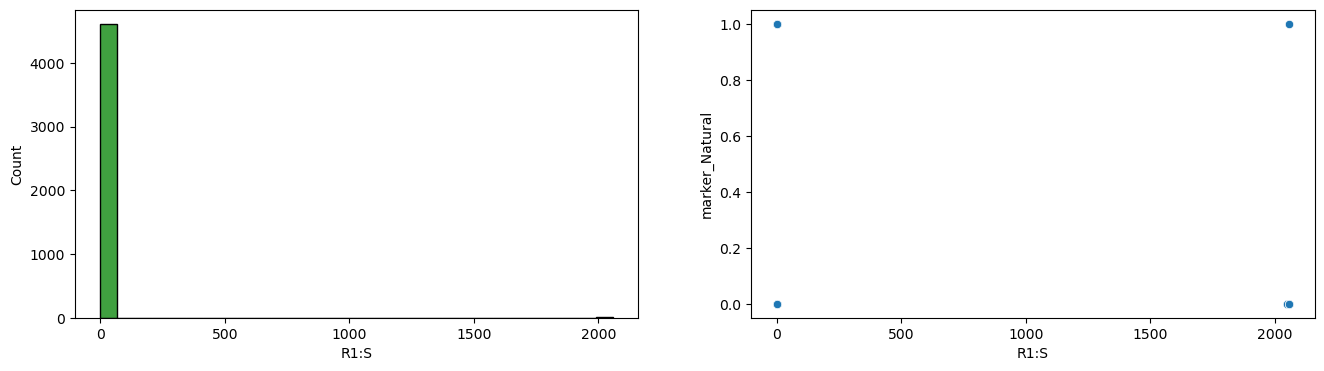

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


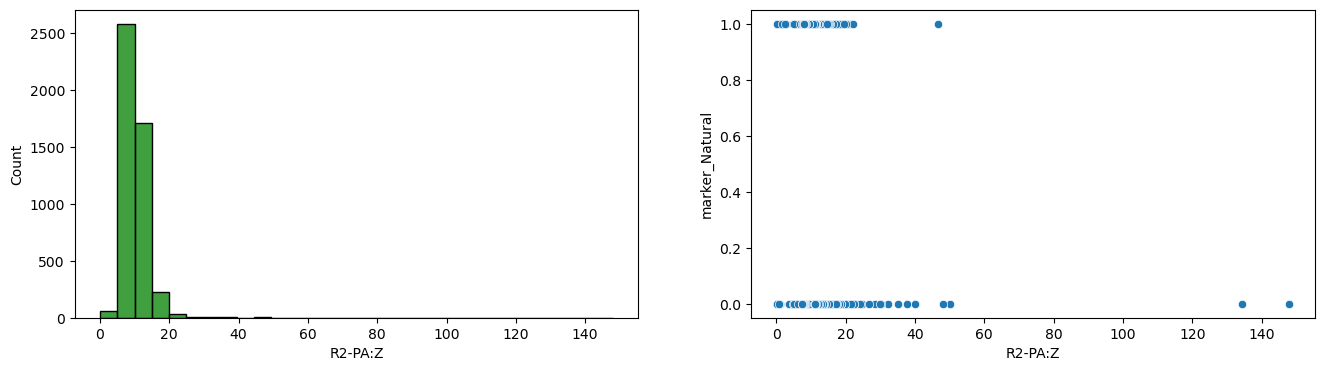

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


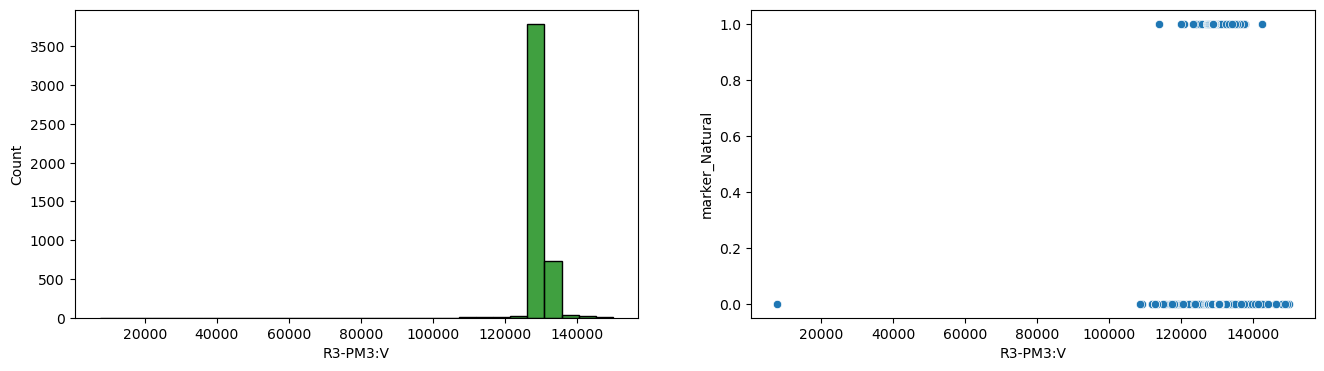

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


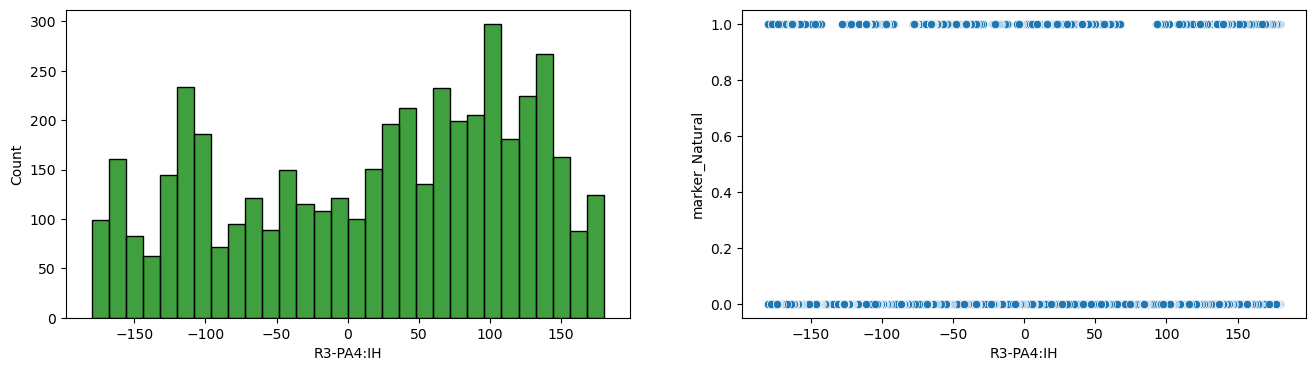

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


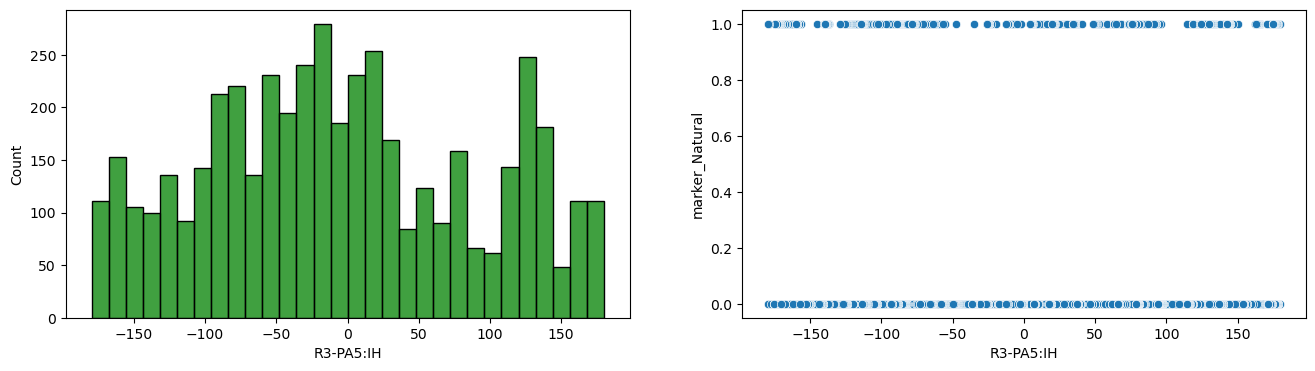

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


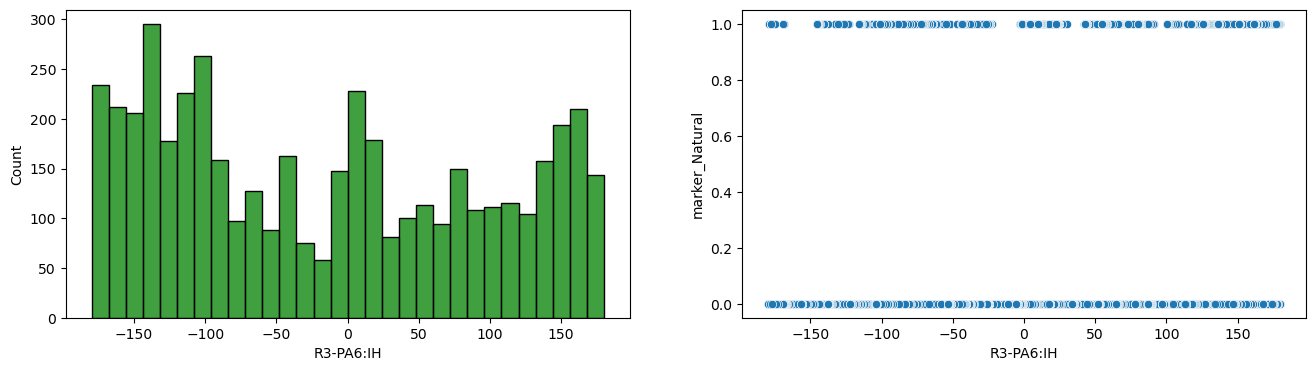

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


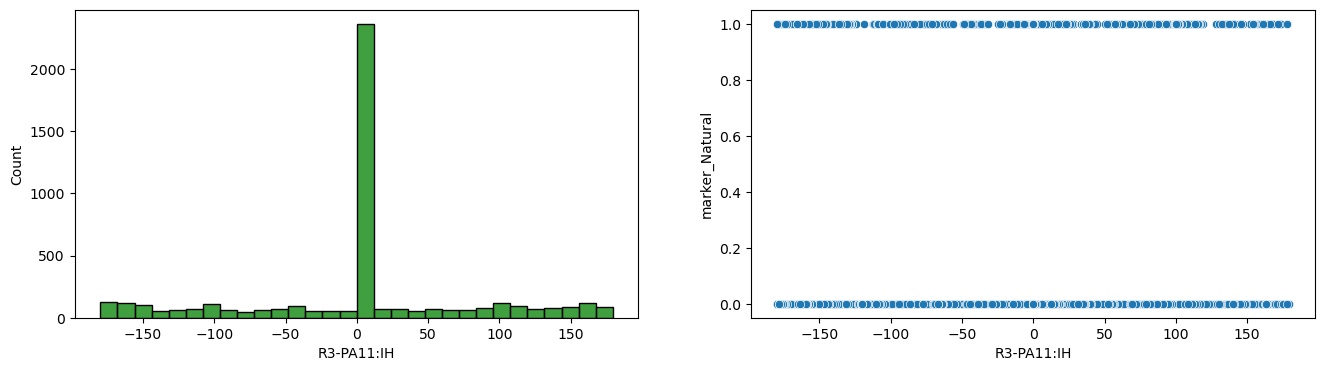

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


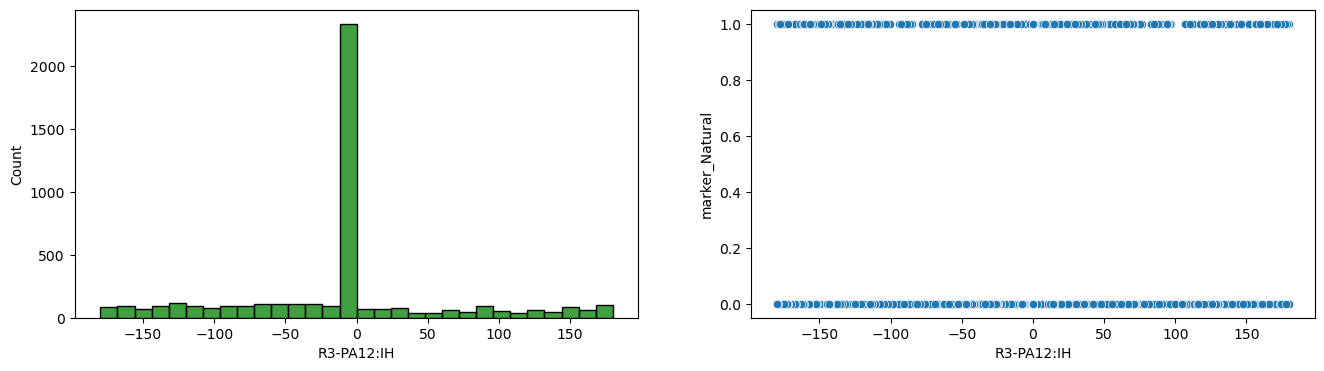

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


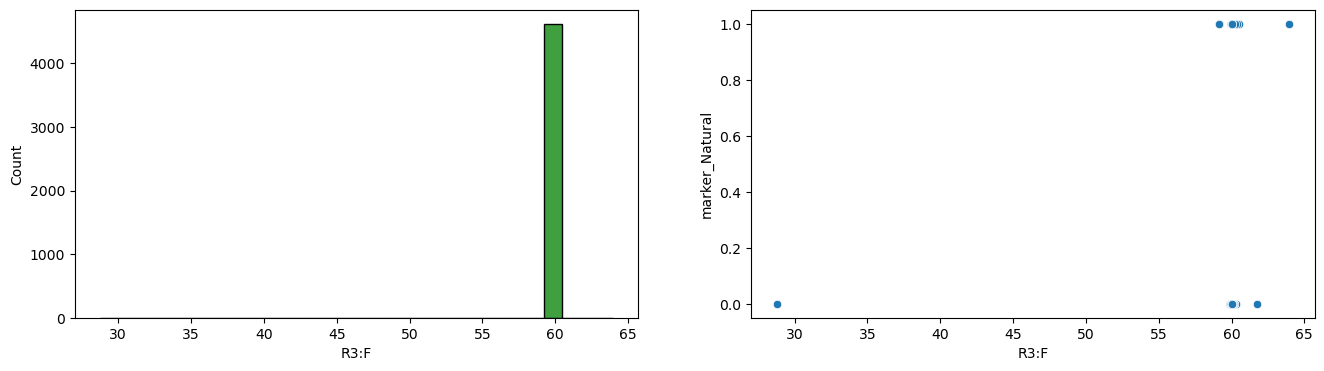

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


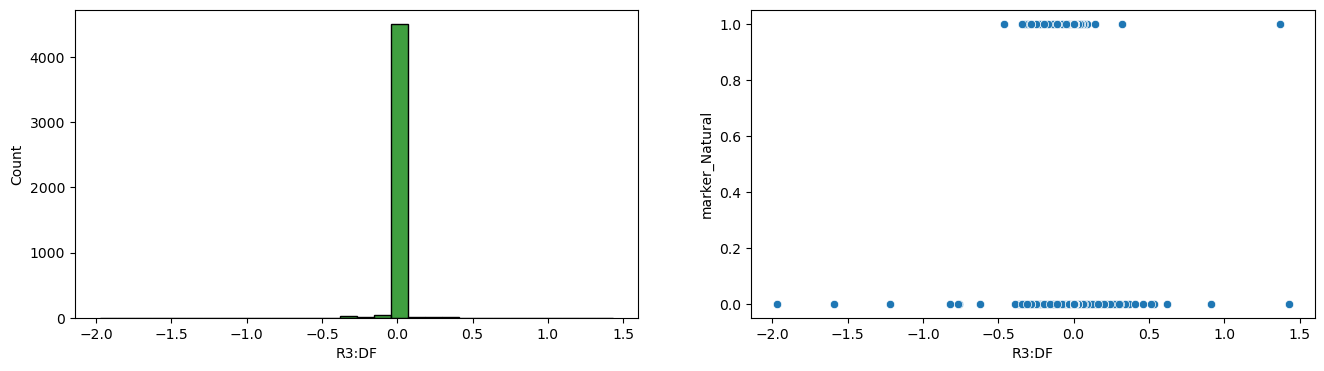

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


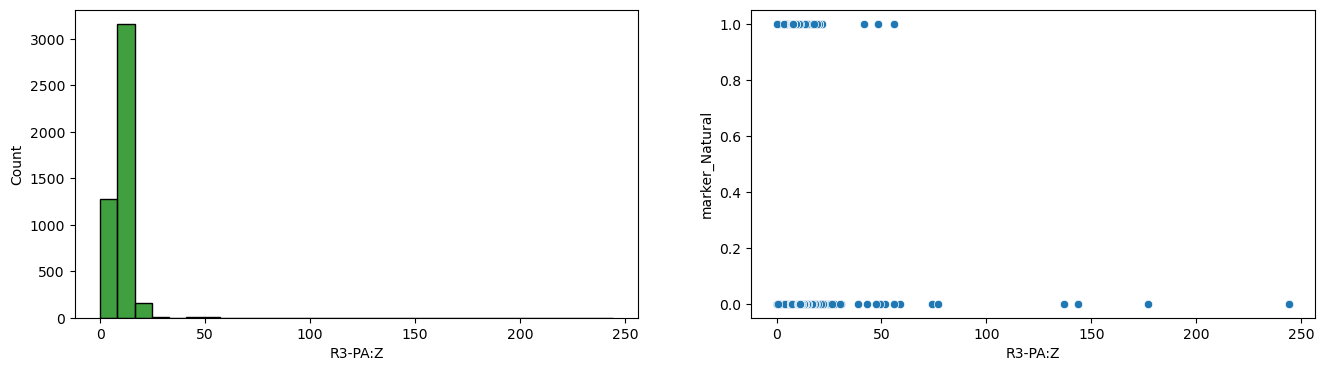

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


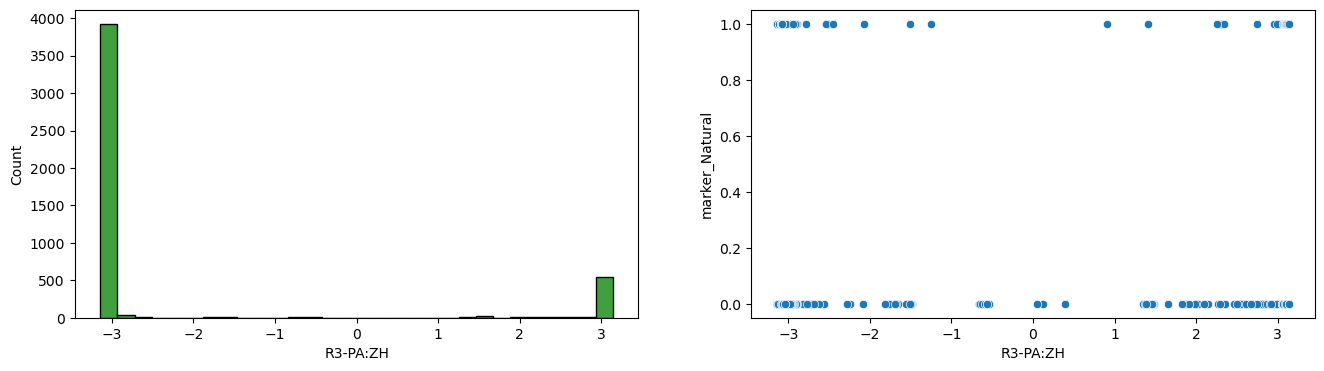

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


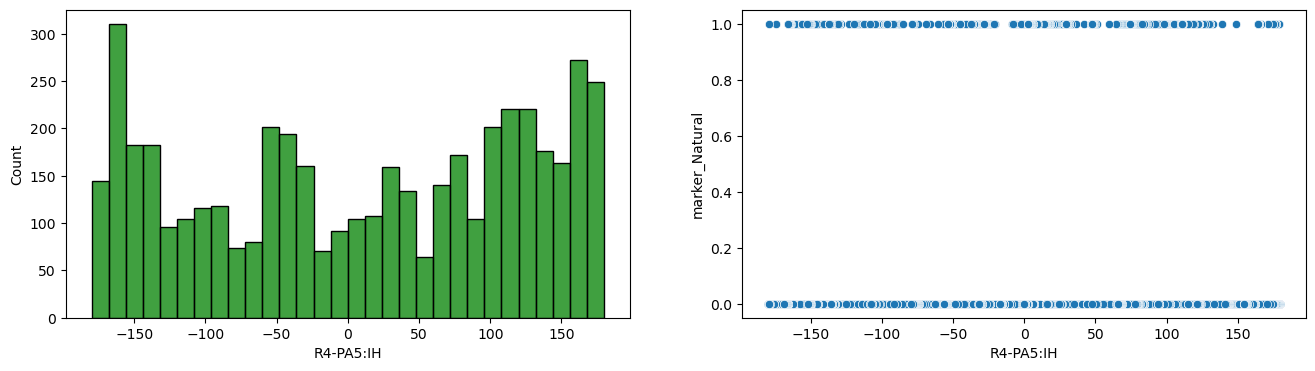

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


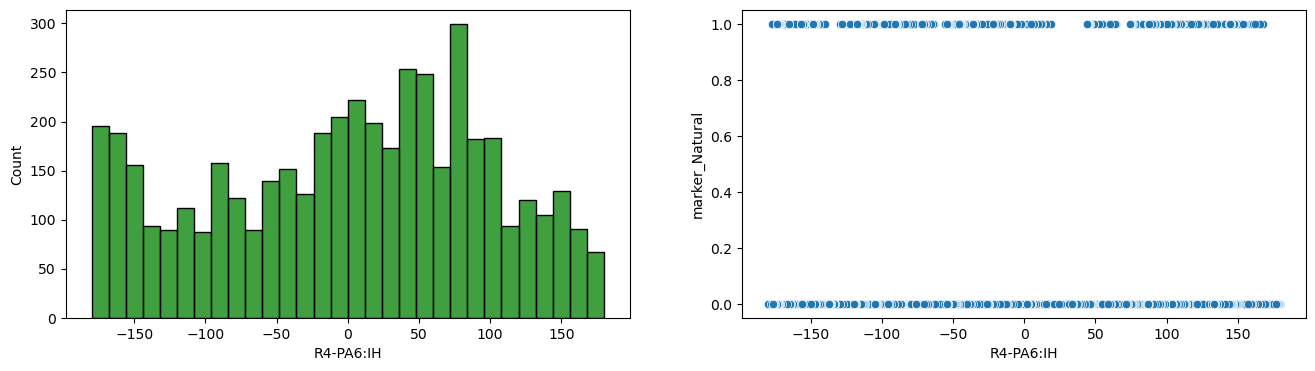

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


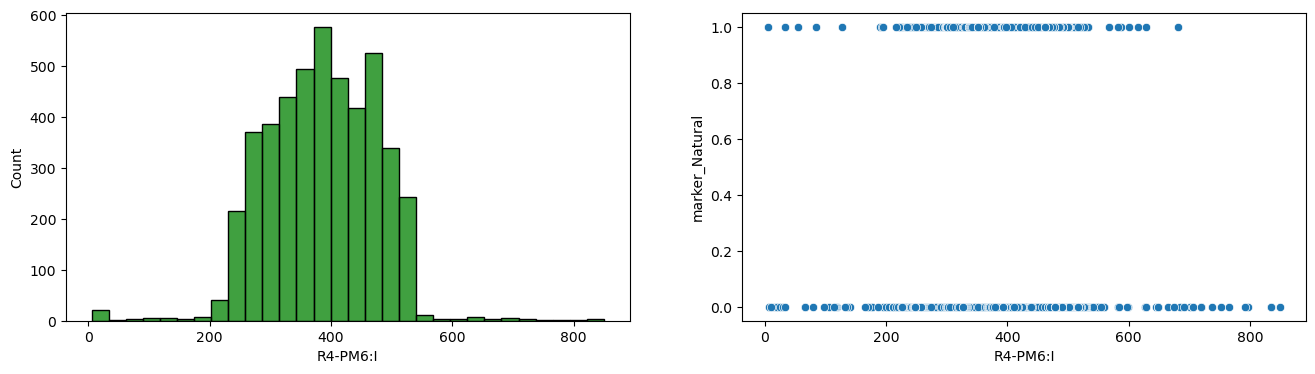

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


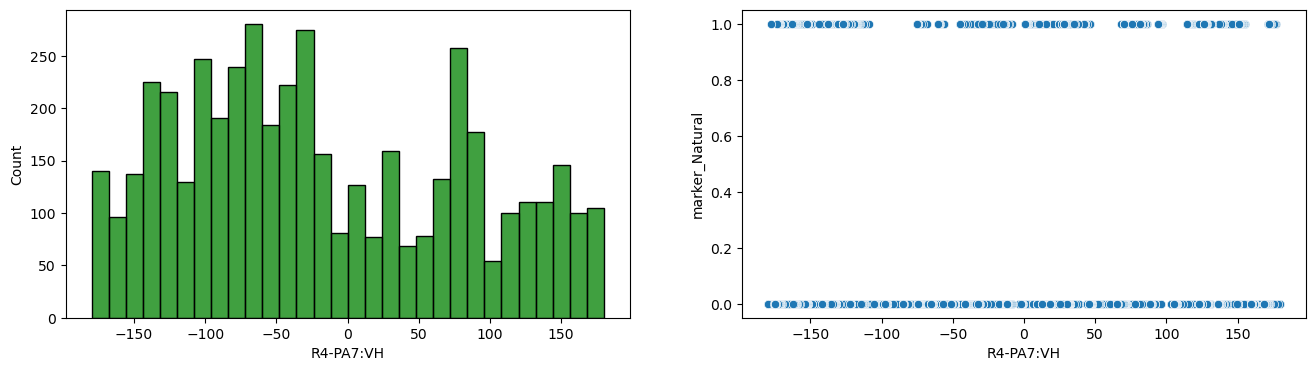

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


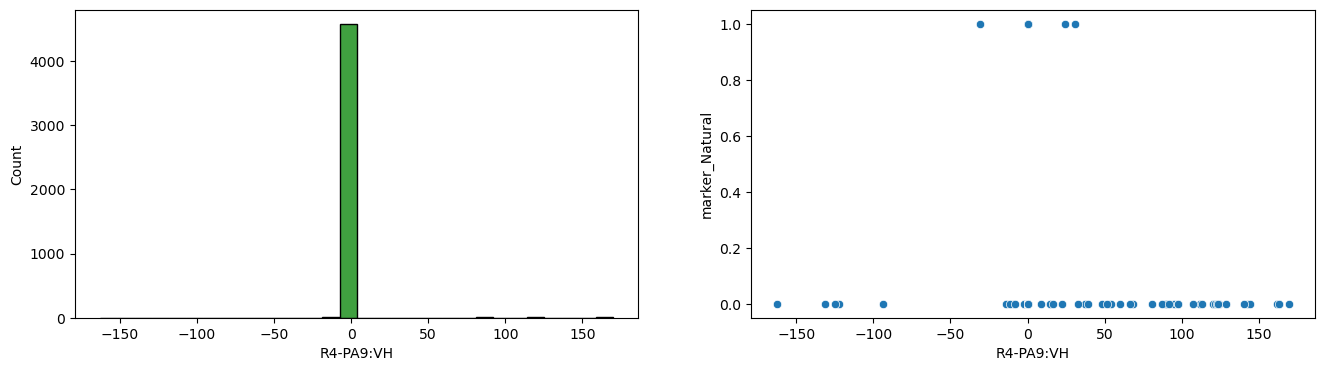

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


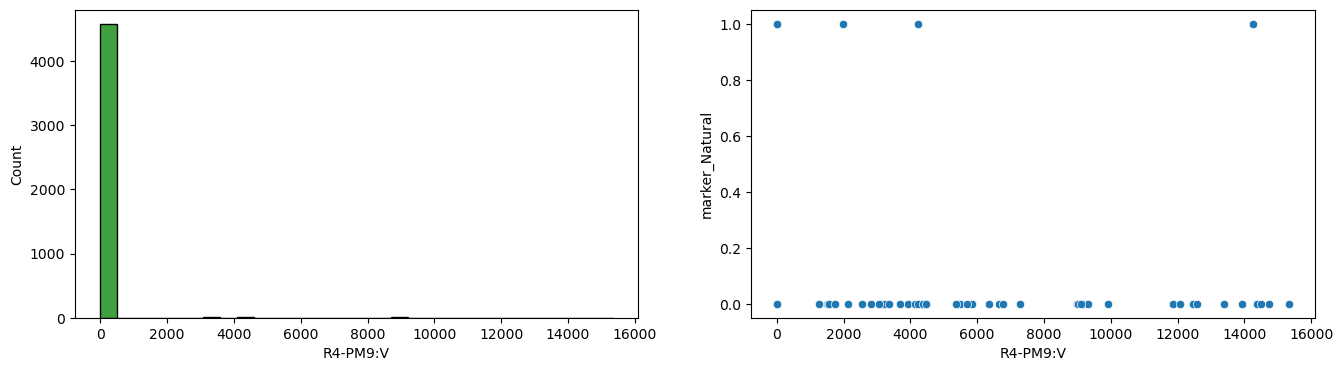

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


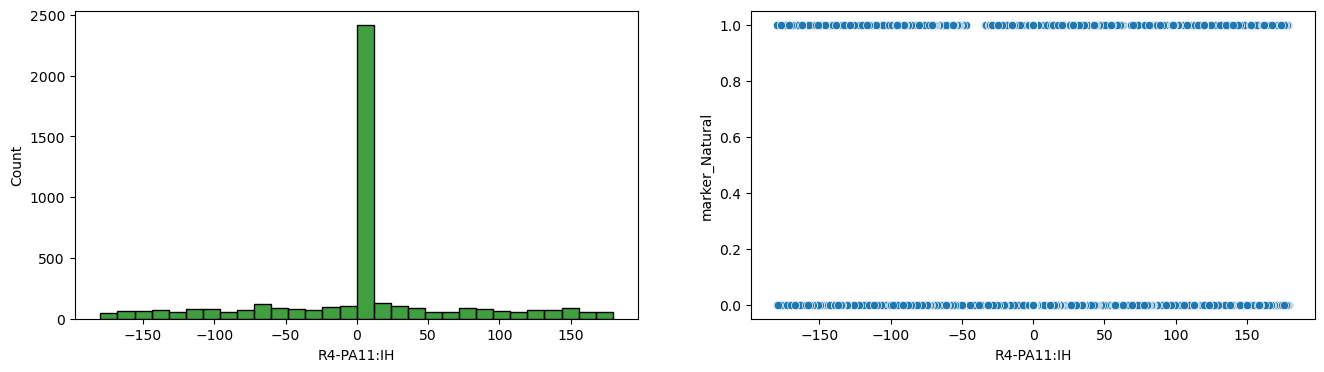

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


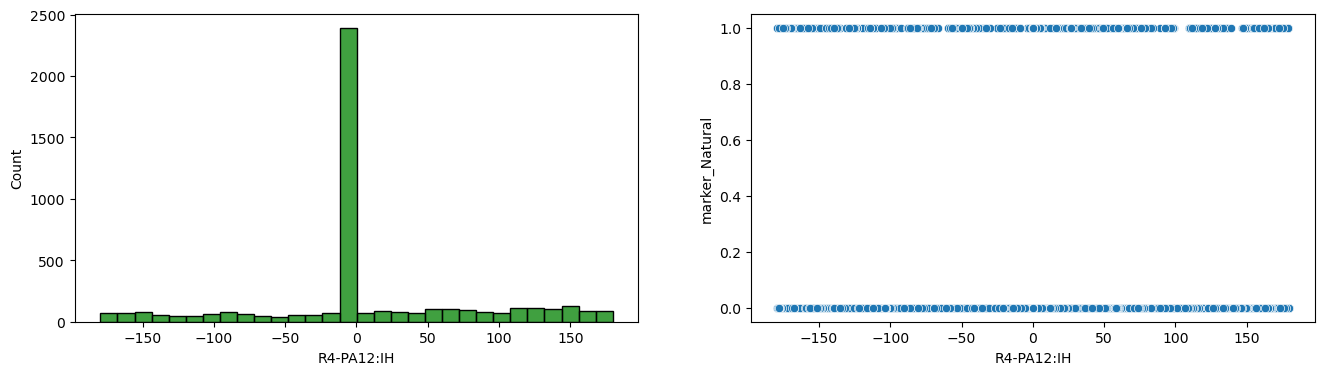

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


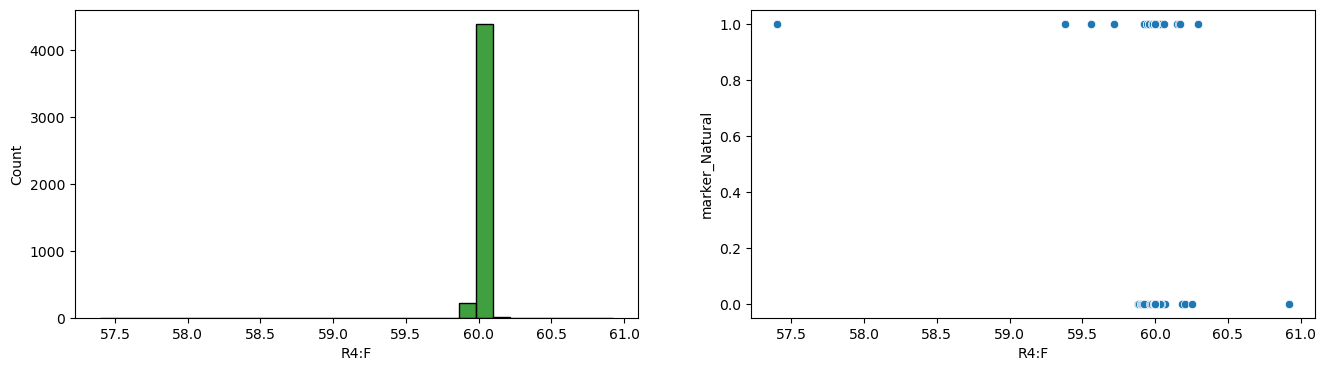

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


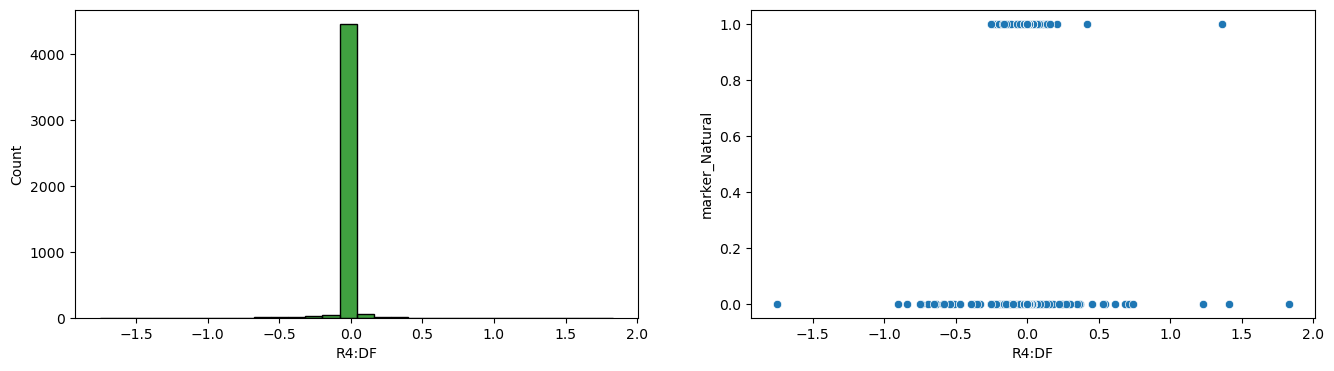

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


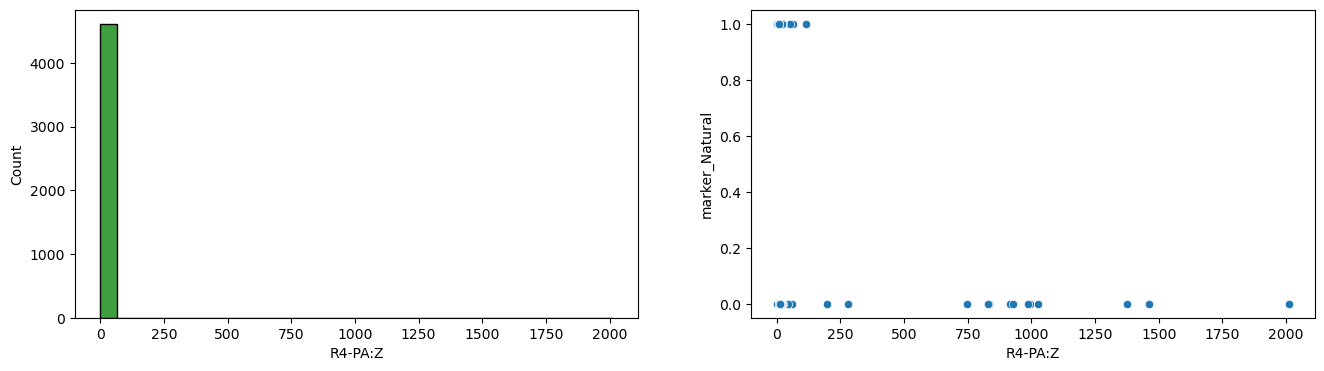

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


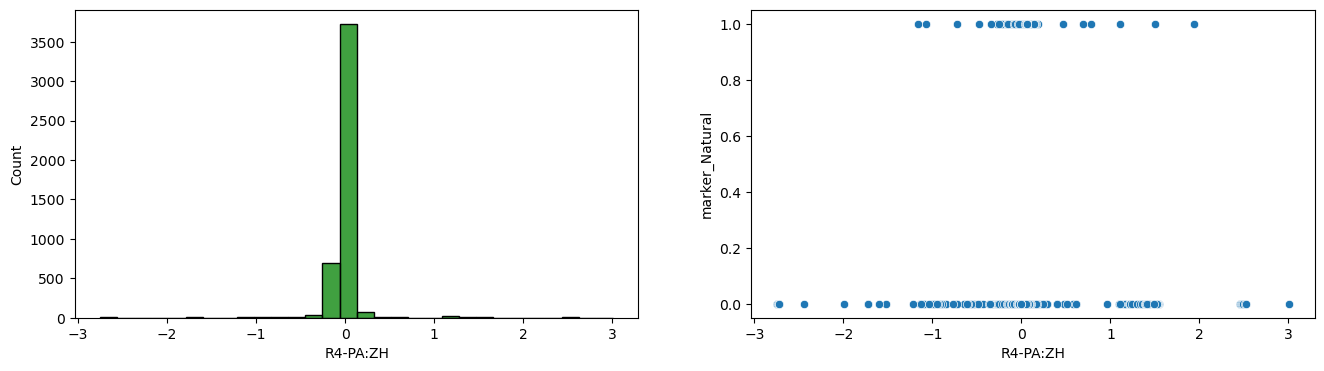

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


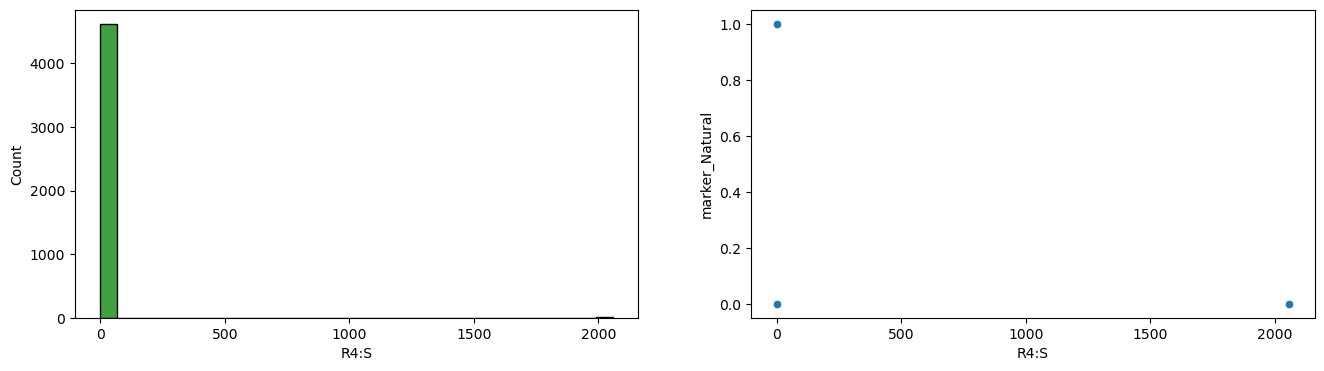

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


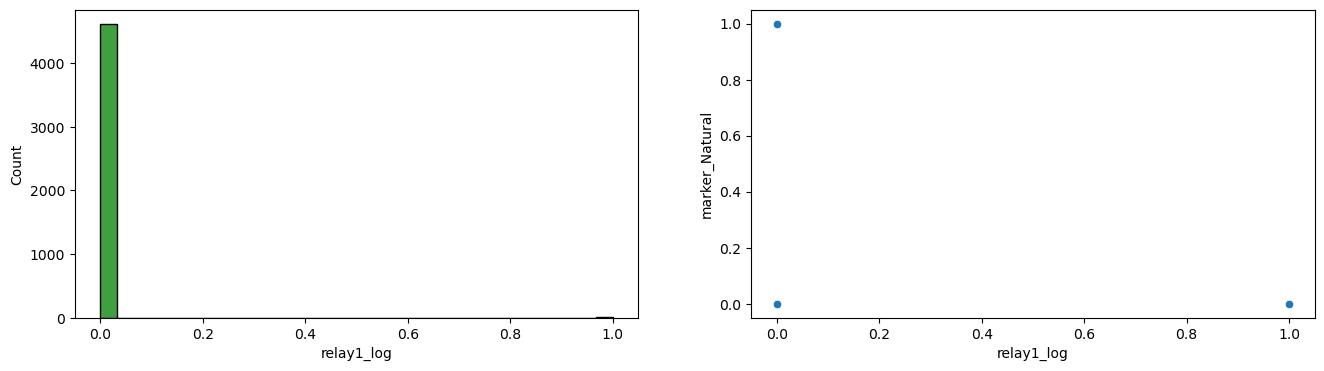

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


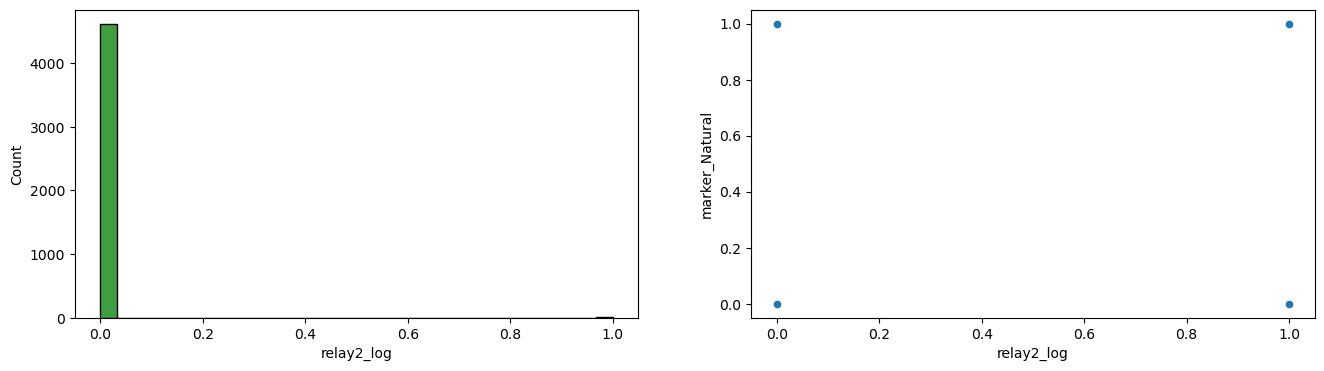

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


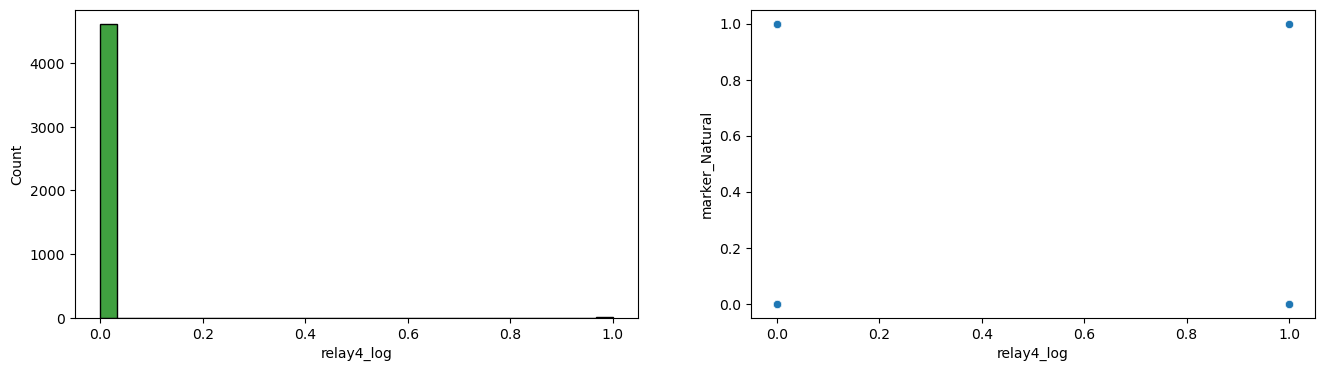

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the assessment function
def assessment(f_data, f_y_feature, f_x_feature, f_index=-1):
    """
    Develops and displays a histogram and a scatter plot for a dependent / independent variable pair from
    a dataframe and, optionally, highlights a specific observation on the plot in a different color (red).
    
    Also optionally, if an independent feature is not informed, the scatterplot is not displayed.
    
    Keyword arguments:
    
    f_data      DataFrame containing the dependent / independent variable pair.
                Pandas DataFrame
    f_y_feature Dependent variable designation (e.g., 'marker_Attack').
                String
    f_x_feature Independent variable designation (e.g., column name).
                String
    f_index     If greater or equal to zero, the observation denoted by f_index will be plotted in red.
                Integer
    """
    # Determine the color for plotting
    if f_index >= 0:
        f_color = np.where(f_data.index == f_index, 'r', 'g')
        f_hue = None
    else:
        f_color = 'b'
        f_hue = None
    
    # Create subplots for histogram and scatter plot
    f_fig, f_a = plt.subplots(1, 2, figsize=(16, 4))
    
    # Plot histogram using sns.histplot with a fixed number of bins
    f_chart1 = sns.histplot(f_data[f_x_feature], ax=f_a[0], bins=30, color='g')
    f_chart1.set_xlabel(f_x_feature, fontsize=10)
    
    # Plot scatter plot (if independent feature is provided)
    if f_index >= 0:
        f_chart2 = plt.scatter(f_data[f_x_feature], f_data[f_y_feature], c=f_color, edgecolors='w')
        f_chart2 = plt.xlabel(f_x_feature, fontsize=10)
        f_chart2 = plt.ylabel(f_y_feature, fontsize=10)
    else:
        f_chart2 = sns.scatterplot(x=f_x_feature, y=f_y_feature, data=f_data, hue=f_hue, legend=False)
        f_chart2.set_xlabel(f_x_feature, fontsize=10)
        f_chart2.set_ylabel(f_y_feature, fontsize=10)

    plt.show()

# Assess relationships for 'marker_Natural' and other columns in df_encoded_filtered
for column in df_encoded_filtered.columns:
    if column != 'marker_Natural':  # Skip the dependent variable itself
        assessment(df_encoded_filtered, 'marker_Natural', column, -1)


In [10]:
df_encoded_filtered.shape

(4618, 30)

In [11]:
X = df_encoded_filtered.iloc[:, :28]
y = df_encoded_filtered.iloc[:, 29]
y

0       True
1       True
2       True
3       True
4       True
        ... 
4961    True
4962    True
4963    True
4964    True
4965    True
Name: marker_Natural, Length: 4618, dtype: bool

In [12]:
X_training = X.iloc[:3500, :]
y_training = y.iloc[:3500]

X_testing = X.iloc[3500:, :]
y_testing = y.iloc[3500:]

ratio_training = y_training.value_counts(normalize=True)
ratio_testing = y_testing.value_counts(normalize=True)
ratio_training, ratio_testing

(marker_Natural
 False    0.884857
 True     0.115143
 Name: proportion, dtype: float64,
 marker_Natural
 True     0.541145
 False    0.458855
 Name: proportion, dtype: float64)

In [13]:
X_training = X_training.values
y_training = y_training.values

X_testing = X_testing.values
y_testing = y_testing.values

X_testing

array([[ 0.        ,  0.        , 11.6338548 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 11.61708019, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 11.62048791, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  7.91699977, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  7.91366602, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  7.90371637, ...,  0.        ,
         0.        ,  0.        ]])

In [14]:
y_testing

array([ True,  True,  True, ...,  True,  True,  True])

In [15]:
scaler = StandardScaler()
X_training = scaler.fit_transform(X_training)
X_testing = scaler.transform(X_testing)

In [16]:
# ANN initialization
classifier = Sequential()

# Input layer and first hidden layer
classifier.add(Dense(units = 28, kernel_initializer = 'uniform', activation = 'relu', input_dim = 28))

# Single-node output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# ANN compilation
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


C:\Users\rvaru\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
cross_val_round = 1
print(f'Model evaluation\n')

for train_index, val_index in KFold(10, shuffle=True, random_state=10).split(X_training):
    x_train, x_val = X_training[train_index], X_training[val_index]
    y_train ,y_val = y_training[train_index], y_training[val_index]
    classifier.fit(x_train, y_train, epochs=3, verbose=0)
    classifier_loss, classifier_accuracy = classifier.evaluate(x_val, y_val)
    print(f'Round {cross_val_round} - Loss: {classifier_loss:.4f} | Accuracy: {classifier_accuracy * 100:.2f} %')
    cross_val_round += 1

Model evaluation

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7986 - loss: 0.4217  
Round 1 - Loss: 0.3913 | Accuracy: 84.57 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8589 - loss: 0.3401 
Round 2 - Loss: 0.3355 | Accuracy: 88.57 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8532 - loss: 0.2902 
Round 3 - Loss: 0.2732 | Accuracy: 89.71 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8346 - loss: 0.3153 
Round 4 - Loss: 0.2986 | Accuracy: 87.71 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8599 - loss: 0.2620 
Round 5 - Loss: 0.2500 | Accuracy: 89.14 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8589 - loss: 0.2620 
Round 6 - Loss: 0.2917 | Accuracy: 88.57 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8827 - loss: 0.2311 
Round 7 - Loss: 0.2610 | Accuracy: 89.14 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8780 - loss: 0.2272 
Round 8 - Loss: 0.2361 | Accuracy: 90.86 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

In [18]:
y_pred = classifier.predict(X_testing)
y_pred

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([[0.14208902],
       [0.14293557],
       [0.1433741 ],
       ...,
       [0.10146166],
       [0.1010189 ],
       [0.10157523]], dtype=float32)

In [19]:
y_pred
y_pred_bool=[]
for i in y_pred:
    if (i[0]>0.5):
        y_pred_bool.append(False)
    else :
        y_pred_bool.append(True)

In [20]:
# Calculate metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
accuracy = accuracy_score(y_testing, y_pred_bool)
f1 = f1_score(y_testing, y_pred_bool)
conf_matrix = confusion_matrix(y_testing, y_pred_bool)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.5420
F1 Score: 0.7027
Confusion Matrix:
[[  1 512]
 [  0 605]]


In [21]:
"""import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense

# ANN initialization using an LSTM architecture
classifier = Sequential()

# Input LSTM layer
# Let's say 'time_steps' = 10 and 'num_features' = 28 as an example
classifier.add(LSTM(units=50, return_sequences=True, input_shape=(10, 28)))
classifier.add(LSTM(units=20, return_sequences=False))  # Second LSTM layer

# Single-node output layer for binary classification
classifier.add(Dense(units=1, activation='sigmoid'))

# Compile the LSTM model
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])"""

"import numpy as np\nfrom keras.models import Sequential\nfrom keras.layers import LSTM, Dense\n\n# ANN initialization using an LSTM architecture\nclassifier = Sequential()\n\n# Input LSTM layer\n# Let's say 'time_steps' = 10 and 'num_features' = 28 as an example\nclassifier.add(LSTM(units=50, return_sequences=True, input_shape=(10, 28)))\nclassifier.add(LSTM(units=20, return_sequences=False))  # Second LSTM layer\n\n# Single-node output layer for binary classification\nclassifier.add(Dense(units=1, activation='sigmoid'))\n\n# Compile the LSTM model\nclassifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])"

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Assuming df_encoded_filtered is already defined and preprocessed
X = df_encoded_filtered.iloc[:, :28]  # Features
y = df_encoded_filtered.iloc[:, 29]   # Labels

# Split into training and testing sets
X_training = X.iloc[:3500, :]
y_training = y.iloc[:3500]
X_testing = X.iloc[3500:, :]
y_testing = y.iloc[3500:]

# Normalize training and testing data
scaler = StandardScaler()
X_training = scaler.fit_transform(X_training)
X_testing = scaler.transform(X_testing)

# Reshape data for LSTM: [samples, time_steps, features]
# Here we choose 1 time step and 28 features (arbitrary choice since we don't have sequence data)
X_training = X_training.reshape((X_training.shape[0], 1, X_training.shape[1]))
X_testing = X_testing.reshape((X_testing.shape[0], 1, X_testing.shape[1]))

# Define the LSTM model
classifier = Sequential()
classifier.add(LSTM(50, return_sequences=True, input_shape=(1, 28)))  # Adjusted for input shape
classifier.add(LSTM(20, return_sequences=False))
classifier.add(Dense(1, activation='sigmoid'))

# Compile the LSTM model
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# KFold Cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=10)
cross_val_round = 1
print('Model evaluation\n')

for train_index, val_index in kf.split(X_training):
    x_train, x_val = X_training[train_index], X_training[val_index]
    y_train, y_val = y_training[train_index], y_training[val_index]
    
    # Fit the model
    classifier.fit(x_train, y_train, epochs=3, batch_size=32, verbose=0)
    
    # Evaluate the model
    classifier_loss, classifier_accuracy = classifier.evaluate(x_val, y_val, verbose=0)
    print(f'Round {cross_val_round} - Loss: {classifier_loss:.4f} | Accuracy: {classifier_accuracy * 100:.2f} %')
    cross_val_round += 1


Model evaluation



C:\Users\rvaru\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyError: '[738, 739, 753, 777, 778, 779, 780, 799, 800, 812, 834, 847, 864, 865, 866, 887, 888, 901, 916, 928, 939, 940, 971, 972, 1038, 1073, 1074, 1075, 1093, 1094, 1119, 1120, 1121, 1151, 1152, 1153, 1349, 1350, 1352, 1384, 1417, 1418, 1445, 1498, 1499, 1500, 1527, 1528, 1557, 1558, 1583, 1584, 1609, 1666, 1667, 1697, 1698, 1721, 1751, 1752, 1753, 1754, 1794, 1795, 1833, 1863, 1864, 1865, 1866, 1901, 1902, 1903, 1933, 1934, 1964, 1965, 2002, 2003, 2031, 2032, 2033, 2034, 2070, 2109, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2191, 2192, 2193, 2194, 2195, 2230, 2277, 2300, 2301, 2302, 2303, 2304, 2305, 2331, 2364, 2365, 2366, 2393, 2394, 2395, 2424, 2426, 2453, 2454, 2484, 2516, 2517, 2518, 2519, 2548, 2581, 2706, 2707, 2739, 2740, 2780, 2823, 2839, 2840, 2841, 2870, 2889, 2897, 2915, 2916, 2942, 2958, 2959, 2978, 2990, 2991, 2992, 3021, 3022, 3023, 3051, 3075, 3111, 3112, 3113, 3114, 3148, 3165, 3166, 3167, 3168, 3191, 3192, 3193, 3194, 3195, 3211, 3212, 3213, 3214, 3227, 3243, 3245, 3267, 3310, 3311, 3312, 3313, 3314, 3342, 3364, 3390, 3417, 3436, 3456, 3475, 3476, 3499] not in index'

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Assuming df_encoded_filtered is already defined and preprocessed
X = df_encoded_filtered.iloc[:, :28]  # Features
y = df_encoded_filtered.iloc[:, 29]   # Labels

# Split into training and testing sets
X_training = X.iloc[:3500, :]
y_training = y.iloc[:3500].reset_index(drop=True)  # Reset index

X_testing = X.iloc[3500:, :]
y_testing = y.iloc[3500:].reset_index(drop=True)  # Reset index

# Normalize training and testing data
scaler = StandardScaler()
X_training = scaler.fit_transform(X_training)
X_testing = scaler.transform(X_testing)

# Reshape data for LSTM: [samples, time_steps, features]
X_training = X_training.reshape((X_training.shape[0], 1, X_training.shape[1]))
X_testing = X_testing.reshape((X_testing.shape[0], 1, X_testing.shape[1]))

# Define the LSTM model
classifier = Sequential()
classifier.add(LSTM(20, return_sequences=True, input_shape=(1, 28)))  # Adjusted for input shape
classifier.add(LSTM(20, return_sequences=False))
classifier.add(Dense(1, activation='sigmoid'))

# Compile the LSTM model
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# KFold Cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=10)
cross_val_round = 1
print('Model evaluation\n')

for train_index, val_index in kf.split(X_training):
    x_train, x_val = X_training[train_index], X_training[val_index]
    y_train, y_val = y_training[train_index], y_training[val_index]

    # Fit the model
    classifier.fit(x_train, y_train, epochs=3, batch_size=32, verbose=0)

    # Evaluate the model
    classifier_loss, classifier_accuracy = classifier.evaluate(x_val, y_val, verbose=0)
    print(f'Round {cross_val_round} - Loss: {classifier_loss:.4f} | Accuracy: {classifier_accuracy * 100:.2f} %')
    cross_val_round += 1


C:\Users\rvaru\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model evaluation

Round 1 - Loss: 0.3863 | Accuracy: 84.29 %
Round 2 - Loss: 0.3187 | Accuracy: 88.57 %
Round 3 - Loss: 0.2545 | Accuracy: 90.29 %
Round 4 - Loss: 0.2752 | Accuracy: 88.29 %
Round 5 - Loss: 0.2154 | Accuracy: 90.86 %
Round 6 - Loss: 0.2484 | Accuracy: 90.86 %
Round 7 - Loss: 0.2350 | Accuracy: 90.29 %
Round 8 - Loss: 0.1703 | Accuracy: 94.00 %
Round 9 - Loss: 0.2181 | Accuracy: 93.43 %
Round 10 - Loss: 0.1729 | Accuracy: 92.57 %


In [25]:
y_pred = classifier.predict(X_testing)
y_pred
y_pred_bool=[]
for i in y_pred:
    if (i[0]>0.5):
        y_pred_bool.append(False)
    else :
        y_pred_bool.append(True)
        

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [26]:
y_testing

0       True
1       True
2       True
3       True
4       True
        ... 
1113    True
1114    True
1115    True
1116    True
1117    True
Name: marker_Natural, Length: 1118, dtype: bool

In [27]:
confusion_matrix(y_testing, y_pred_bool)

array([[ 41, 472],
       [ 36, 569]], dtype=int64)

In [28]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Assuming y_pred is already calculated using classifier.predict(X_testing)
y_pred_bool = (y_pred.ravel() > 0.5).astype(int)  # Simplified conversion using numpy


In [29]:
# Ensure y_testing is also a proper array of labels (0 or 1)
# If y_testing is not an array of 0s and 1s, you might need to convert or assert this format.

# Calculate Accuracy
accuracy = accuracy_score(y_testing, y_pred_bool)
print(f"Accuracy: {accuracy:.4f}")

# Calculate F1 Score
f1 = f1_score(y_testing, y_pred_bool)
print(f"F1 Score: {f1:.4f}")

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_testing, y_pred_bool)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.4544
F1 Score: 0.1056
Confusion Matrix:
[[472  41]
 [569  36]]


In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Example data loading (replace with your actual dataset)
# X = your dataframe of features
# y = your dataframe or series of target

# Assuming df_encoded_filtered is already defined and preprocessed
X = df_encoded_filtered.iloc[:, :28]  # Features up to the 28th column
y = df_encoded_filtered.iloc[:, 29]   # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Neural Network Architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.05),  # Dropout layer to reduce overfitting
    Dense(64, activation='relu'),
    Dropout(0.05),
    Dense(32, activation='relu'),
    Dropout(0.05),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=175, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Converting probabilities to binary output

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Epoch 1/175


C:\Users\rvaru\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7704 - loss: 0.5448 - val_accuracy: 0.7835 - val_loss: 0.4626
Epoch 2/175
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7887 - loss: 0.4318 - val_accuracy: 0.7794 - val_loss: 0.4517
Epoch 3/175
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7887 - loss: 0.4275 - val_accuracy: 0.7835 - val_loss: 0.4464
Epoch 4/175
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8000 - loss: 0.4193 - val_accuracy: 0.7848 - val_loss: 0.4521
Epoch 5/175
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8009 - loss: 0.4119 - val_accuracy: 0.7848 - val_loss: 0.4441
Epoch 6/175
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7992 - loss: 0.4111 - val_accuracy: 0.7876 - val_loss: 0.4474
Epoch 7/175
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8177 - loss: 0.3822 - val_accuracy: 0.7876 - val_loss: 0.4398
Epoch 8/175
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8191 - loss: 0.3862 - val_accuracy: 0.7862 - val_loss: 0.4